In [1]:
# importing the necessary libraries
import os  # interact with the operating system
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # Used for creating visualizations, including charts and graphs
from PIL import Image  # To load and process images (Python Imaging Library)
import pandas as pd  # For data manipulation and analysis
from collections import Counter  # Useful for counting hashable objects 
from PIL import ImageStat  # Provides statistics about images
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images.
import warnings # ignores the unnecessary warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Define the base directory for the dataset
base_dir = "../dataset/"

# Constructing paths for training, validation, and test datasets
train_dir = os.path.join(base_dir, 'train') # Path for the training data
val_dir = os.path.join(base_dir, 'val') # Path for the validation data
test_dir = os.path.join(base_dir, 'test') # Path for the test data

In [3]:
def load_image_paths_and_labels(data_dir):
    image_paths = []  # Initialize an empty list to store image file paths
    labels = []       # Initialize an empty list to store corresponding labels

    # Iterate over KL grades (0-4) in each directory
    for grade in os.listdir(data_dir):  # Loop through each grade directory in the data directory
        grade_dir = os.path.join(data_dir, grade)  # Construct the full path to the grade directory
        if os.path.isdir(grade_dir):  # Check if the grade_dir is indeed a directory
            # Iterate over image files in the grade directory
            for img_file in os.listdir(grade_dir):  # Loop through each image file in the grade directory
                img_path = os.path.join(grade_dir, img_file)  # Construct the full path to the image file
                image_paths.append(img_path)  # Append the image path to the list
                labels.append(int(grade))  # Append the KL grade as an integer to the labels list
    return image_paths, labels  # Return the lists of image paths and labels


In [4]:
# Load training images and their corresponding labels
train_images, train_labels = load_image_paths_and_labels(train_dir)

# Load validation images and their corresponding labels
val_images, val_labels = load_image_paths_and_labels(val_dir)

# Load test images and their corresponding labels
test_images, test_labels = load_image_paths_and_labels(test_dir)

In [5]:
# Create a DataFrame for the training dataset with image paths and labels
train_df = pd.DataFrame({"image_path": train_images, "label": train_labels})

# Create a DataFrame for the validation dataset with image paths and labels
val_df = pd.DataFrame({"image_path": val_images, "label": val_labels})

# Create a DataFrame for the test dataset with image paths and labels
test_df = pd.DataFrame({"image_path": test_images, "label": test_labels})

In [6]:
# Concatenate the training, validation, and test DataFrames into a single DataFrame
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [7]:
def check_duplicate_images(df):
    image_hashes = []  # Initialize a list to store hashes of unique images
    duplicates = []     # Initialize a list to store paths of duplicate images
    
    # Iterate over each image path in the DataFrame
    for img_path in df['image_path']:
        img = Image.open(img_path).convert('L')  # Open the image and convert it to grayscale
        img_hash = hash(img.tobytes())  # Create a hash of the image's byte data for comparison
        
        # Check if the image hash is already in the list of hashes
        if img_hash in image_hashes:
            duplicates.append(img_path)  # If it is, add to the duplicates list
        else:
            image_hashes.append(img_hash)  # If not, add the hash to the list of unique hashes
    
    # Print the result of the duplicate check
    if duplicates:
        print(f"Found {len(duplicates)} duplicate images.")  # Report the number of duplicates found
    else:
        print("No duplicates found.")  # Indicate no duplicates were found
    
    return duplicates  # Return the list of duplicate image paths

# Check for duplicate images in the training set
duplicates = check_duplicate_images(train_df)  # Call the function and store the duplicate paths

No duplicates found.


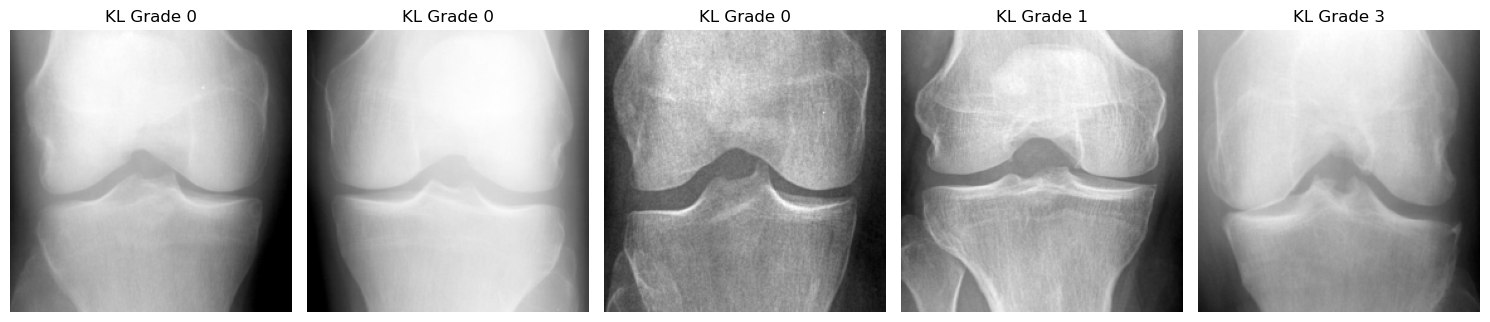

In [8]:
# Display random sample images from the training set
def show_sample_images(df, num_samples=5):
    plt.figure(figsize=(15, 5))  # Set the figure size for the plot
    sample_df = df.sample(num_samples)  # Randomly sample 'num_samples' images from the DataFrame
    
    # Iterate over the sampled images and their labels
    for i, (img_path, label) in enumerate(zip(sample_df['image_path'], sample_df['label'])):
        img = Image.open(img_path)  # Open the image using its file path
        plt.subplot(1, num_samples, i + 1)  # Create a subplot for each image
        plt.imshow(img, cmap='gray')  # Display the image (in grayscale)
        plt.title(f"KL Grade {label}")  # Set the title of the subplot to show the KL grade
        plt.axis('off')  # Turn off the axis for a cleaner look
        
    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()  # Display the plot

# Display random images from the training set
show_sample_images(train_df, num_samples=5)  # Call the function to display 5 random images

In [9]:
def check_corrupted_images(df):
    corrupted = []  # Initialize a list to store paths of corrupted images
    
    # Iterate over each image path in the DataFrame
    for img_path in df['image_path']:
        try:
            img = Image.open(img_path)  # Attempt to open the image
            img.verify()  # Verify the image integrity; raises an exception if corrupted
        except Exception as e:  # Catch any exceptions that occur
            corrupted.append(img_path)  # Add the corrupted image path to the list
    
    # Print the result of the corrupted image check
    if corrupted:
        print(f"Found {len(corrupted)} corrupted images.")  # Report the number of corrupted images found
    else:
        print("No corrupted images found.")  # Indicate that no corrupted images were found
    
    return corrupted  # Return the list of corrupted image paths

# Check for corrupted images in the training set
corrupted_images = check_corrupted_images(train_df)  # Call the function and store the paths of corrupted images

No corrupted images found.


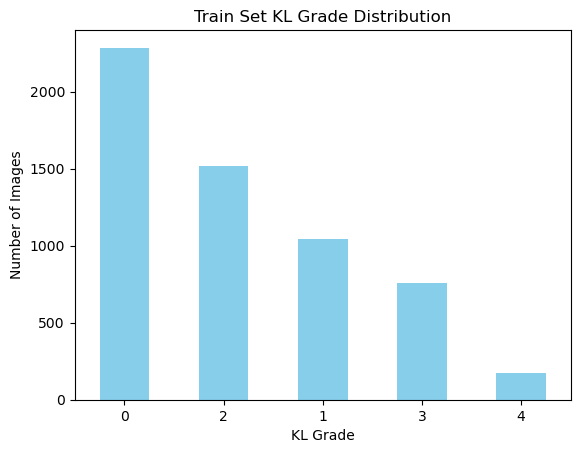

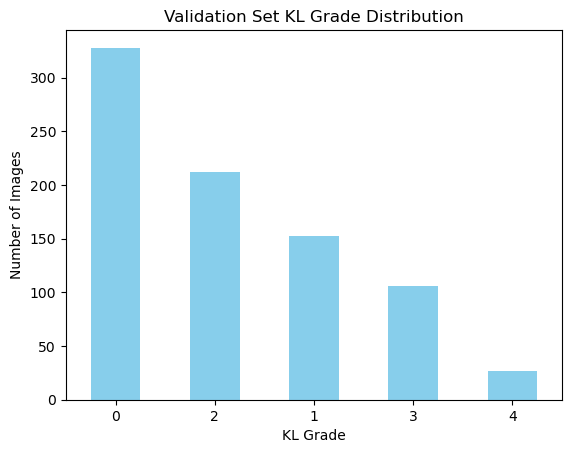

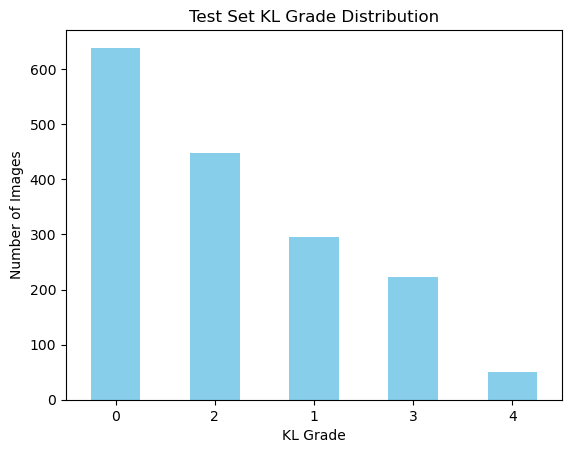

In [10]:
# Check the distribution of KL grades in each split
def plot_label_distribution(df, title):
    label_counts = df['label'].value_counts()  # Count occurrences of each KL grade in the DataFrame
    label_counts.plot(kind='bar', color='skyblue')  # Create a bar plot of the label counts
    plt.title(title)  # Set the plot title
    plt.xlabel('KL Grade')  # Label for the x-axis
    plt.ylabel('Number of Images')  # Label for the y-axis
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.show()  # Display the plot

# Plot distribution for each set
plot_label_distribution(train_df, "Train Set KL Grade Distribution")  # Plot for training set
plot_label_distribution(val_df, "Validation Set KL Grade Distribution")  # Plot for validation set
plot_label_distribution(test_df, "Test Set KL Grade Distribution")  # Plot for test set


In [11]:
# Check basic statistics of images and labels
def dataset_stats(df):
    print("Dataset Statistics:")  # Print header for statistics
    print(f"Total images: {len(df)}")  # Print the total number of images in the DataFrame
    print(f"KL Grade distribution:\n{df['label'].value_counts()}")  # Print the distribution of KL grades

# Print stats for train, val, and test sets
print("Train Set Stats:")  # Indicate that we are printing stats for the training set
dataset_stats(train_df)  # Call the function to print statistics for the training set
print("\nValidation Set Stats:")  # Indicate that we are printing stats for the validation set
dataset_stats(val_df)  # Call the function to print statistics for the validation set
print("\nTest Set Stats:")  # Indicate that we are printing stats for the test set
dataset_stats(test_df)  # Call the function to print statistics for the test set

Train Set Stats:
Dataset Statistics:
Total images: 5778
KL Grade distribution:
label
0    2286
2    1516
1    1046
3     757
4     173
Name: count, dtype: int64

Validation Set Stats:
Dataset Statistics:
Total images: 826
KL Grade distribution:
label
0    328
2    212
1    153
3    106
4     27
Name: count, dtype: int64

Test Set Stats:
Dataset Statistics:
Total images: 1656
KL Grade distribution:
label
0    639
2    447
1    296
3    223
4     51
Name: count, dtype: int64



Image Dimensions Stats:
        width  height
count  5778.0  5778.0
mean    224.0   224.0
std       0.0     0.0
min     224.0   224.0
25%     224.0   224.0
50%     224.0   224.0
75%     224.0   224.0
max     224.0   224.0


Text(0.5, 0, 'Width')

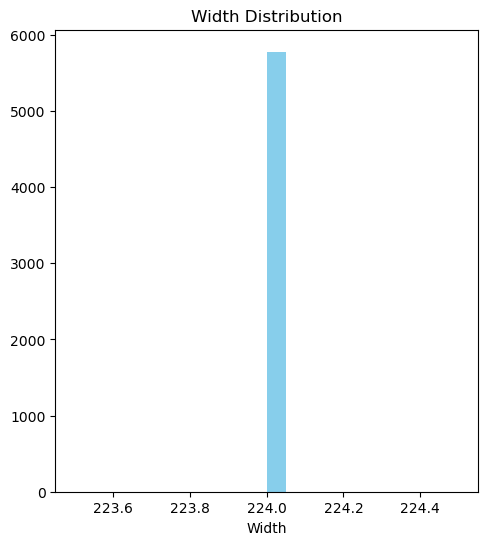

In [12]:
# Check image sizes (dimensions)
def check_image_dimensions(df):
    dimensions = []  # Initialize a list to store image dimensions (width, height)
    
    # Iterate over each image path in the DataFrame
    for img_path in df['image_path']:
        with Image.open(img_path) as img:  # Open the image file
            dimensions.append(img.size)  # Append the size (width, height) to the dimensions list
            
    # Create a DataFrame to store dimensions
    dim_df = pd.DataFrame(dimensions, columns=['width', 'height'])  # Convert dimensions list to DataFrame
    
    print("\nImage Dimensions Stats:")  # Print header for image dimensions statistics
    print(dim_df.describe())  # Print summary statistics (count, mean, std, min, 25%, 50%, 75%, max)
    
    return dim_df  # Return the DataFrame containing image dimensions

# Check image dimensions in the training set
train_dimensions = check_image_dimensions(train_df)  # Call the function and store dimensions

# Plot image dimension distribution
plt.figure(figsize=(12, 6))  # Set figure size for the plot
plt.subplot(1, 2, 1)  # Create the first subplot for width distribution
plt.hist(train_dimensions['width'], bins=20, color='skyblue')  # Create a histogram of image widths
plt.title("Width Distribution")  # Set the title for the width distribution plot
plt.xlabel("Width")  # Label the x-axis

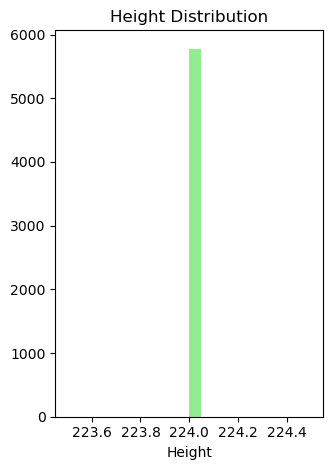

In [13]:
# Plot height distribution of images
plt.subplot(1, 2, 2)  # Create the second subplot for height distribution
plt.hist(train_dimensions['height'], bins=20, color='lightgreen')  # Create a histogram of image heights
plt.title("Height Distribution")  # Set the title for the height distribution plot
plt.xlabel("Height")  # Label the x-axis

plt.tight_layout()  # Adjust the layout to prevent overlap between subplots
plt.show()  # Display the plots

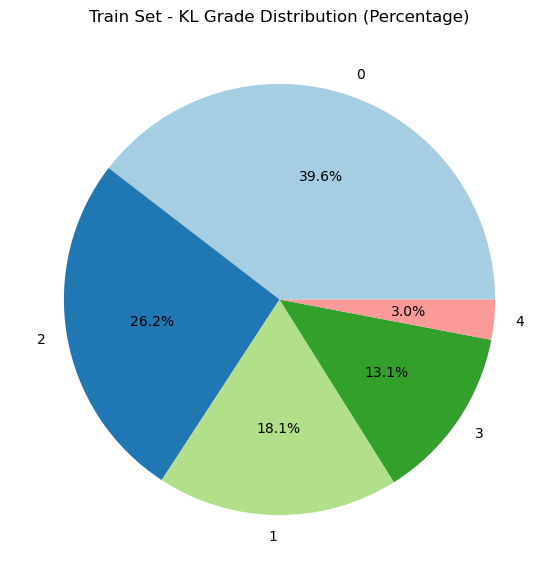

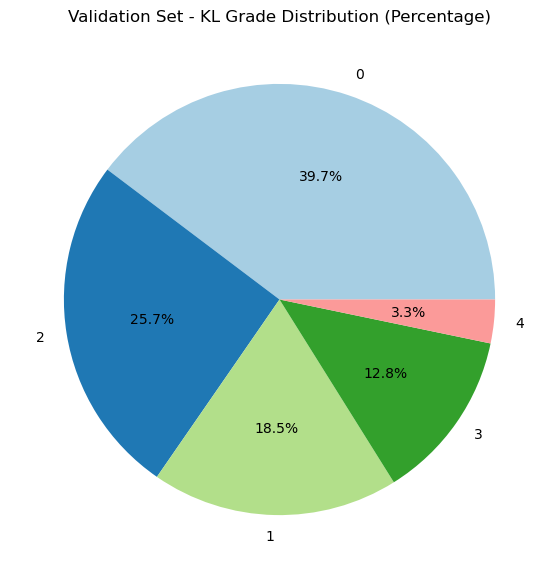

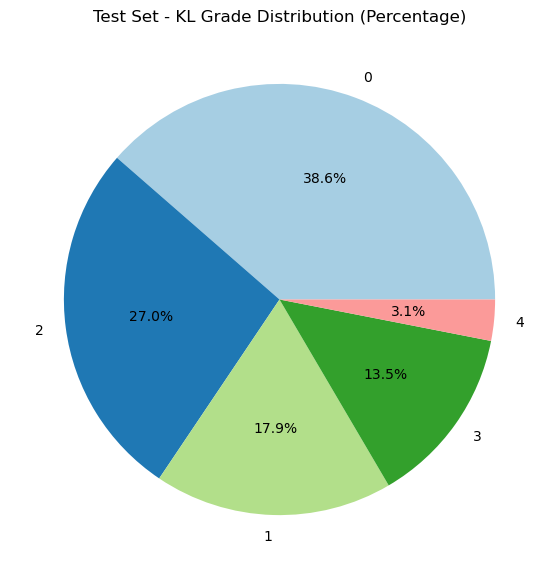

In [14]:
def plot_label_distribution_pie(df, title):
    label_counts = df['label'].value_counts()  # Count occurrences of each KL grade in the DataFrame
    plt.figure(figsize=(7, 7))  # Set figure size for the pie chart
    
    # Create a pie chart showing the distribution of KL grades
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    
    plt.title(f"{title} - KL Grade Distribution (Percentage)")  # Set the title of the pie chart
    plt.show()  # Display the pie chart

# Plot pie charts for each dataset
plot_label_distribution_pie(train_df, "Train Set")  # Pie chart for training set
plot_label_distribution_pie(val_df, "Validation Set")  # Pie chart for validation set
plot_label_distribution_pie(test_df, "Test Set")  # Pie chart for test set

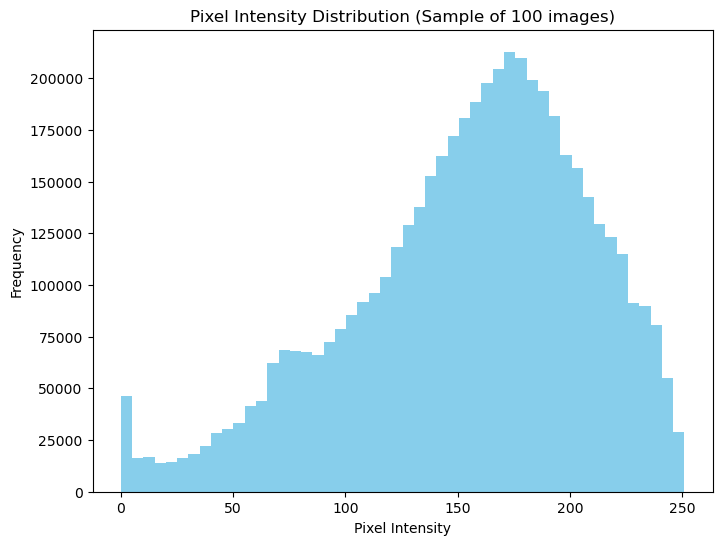

In [15]:
def plot_pixel_intensity_distribution(df, num_samples=100):
    intensities = []  # Initialize a list to store pixel intensity values
    sample_df = df.sample(num_samples)  # Take a random sample of images from the DataFrame
    
    # Iterate over each image path in the sampled DataFrame
    for img_path in sample_df['image_path']:
        img = Image.open(img_path).convert('L')  # Open the image and convert it to grayscale
        intensities.extend(np.array(img).flatten())  # Flatten the image pixel values into a 1D array and add to the intensities list
    
    # Create a histogram to visualize the pixel intensity distribution
    plt.figure(figsize=(8, 6))  # Set figure size for the histogram
    plt.hist(intensities, bins=50, color='skyblue')  # Plot the histogram of pixel intensities
    plt.title(f'Pixel Intensity Distribution (Sample of {num_samples} images)')  # Set the title
    plt.xlabel('Pixel Intensity')  # Label for the x-axis
    plt.ylabel('Frequency')  # Label for the y-axis
    plt.show()  # Display the histogram

# Analyze pixel intensity distribution in the training set
plot_pixel_intensity_distribution(train_df, num_samples=100)  # Call the function for a sample of 100 images

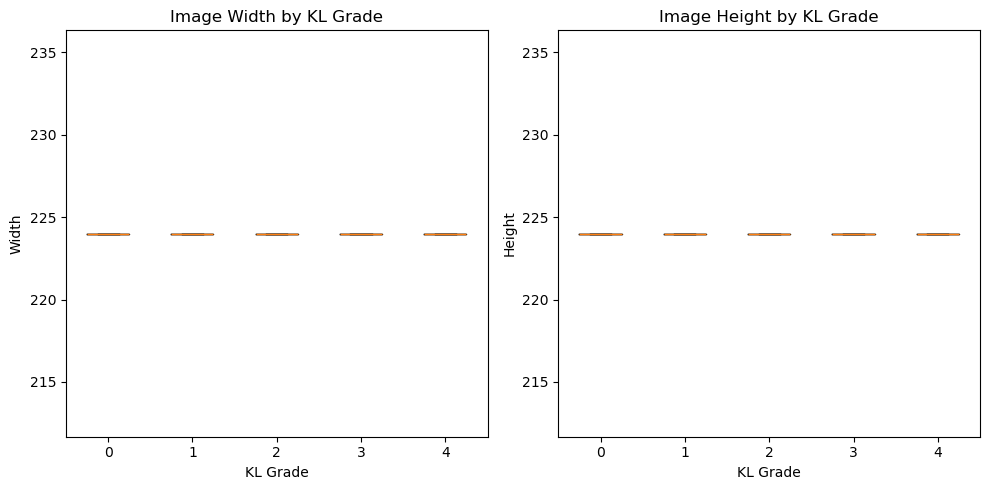

In [16]:
def plot_image_dimensions_vs_kl_grade(df):
    dimensions = []  # Initialize a list to store width, height, and label
    
    # Iterate over each image path and corresponding label
    for img_path, label in zip(df['image_path'], df['label']):
        with Image.open(img_path) as img:  # Open the image file
            dimensions.append((img.size[0], img.size[1], label))  # Append (width, height, label) to the list
    
    # Create a DataFrame from the dimensions list
    dim_df = pd.DataFrame(dimensions, columns=['width', 'height', 'label'])
    
    plt.figure(figsize=(10, 5))  # Set figure size for the plots
    
    # Plot width vs KL grade
    plt.subplot(1, 2, 1)  # Create the first subplot for width distribution
    plt.boxplot([dim_df[dim_df['label'] == kl]['width'] for kl in sorted(dim_df['label'].unique())], 
                labels=sorted(dim_df['label'].unique()))
    plt.title('Image Width by KL Grade')  # Set title for width plot
    plt.xlabel('KL Grade')  # Label x-axis
    plt.ylabel('Width')  # Label y-axis
    
    # Plot height vs KL grade
    plt.subplot(1, 2, 2)  # Create the second subplot for height distribution
    plt.boxplot([dim_df[dim_df['label'] == kl]['height'] for kl in sorted(dim_df['label'].unique())], 
                labels=sorted(dim_df['label'].unique()))
    plt.title('Image Height by KL Grade')  # Set title for height plot
    plt.xlabel('KL Grade')  # Label x-axis
    plt.ylabel('Height')  # Label y-axis
    
    plt.tight_layout()  # Adjust layout to prevent overlap between subplots
    plt.show()  # Display the plots

# Plot image dimensions vs KL grade for the training set
plot_image_dimensions_vs_kl_grade(train_df)  # Call the function for the training dataset

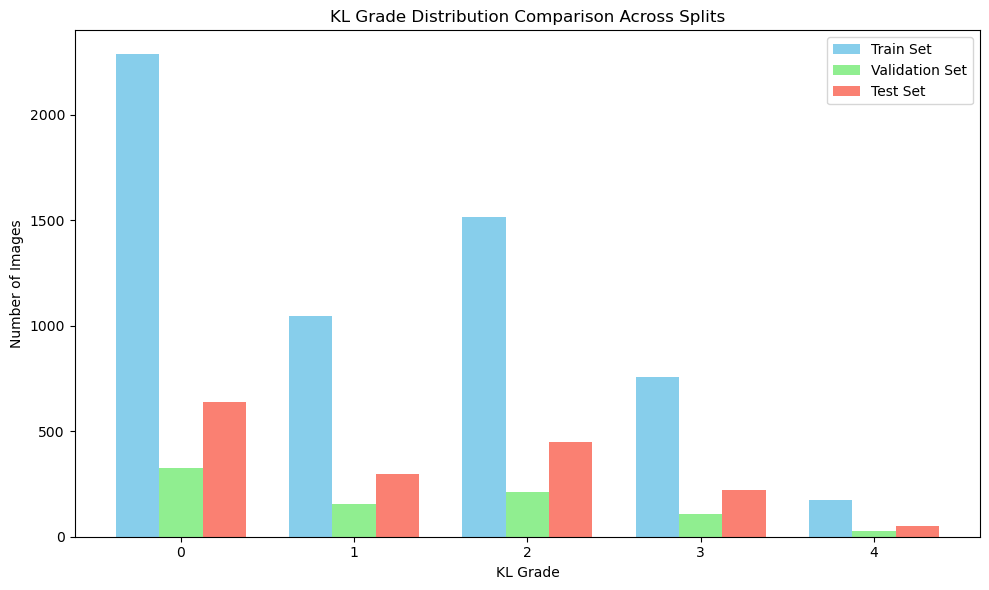

In [17]:
def plot_kl_distribution_comparison(train_df, val_df, test_df):
    # Count occurrences of each KL grade in the training, validation, and test DataFrames
    train_counts = train_df['label'].value_counts().sort_index()
    val_counts = val_df['label'].value_counts().sort_index()
    test_counts = test_df['label'].value_counts().sort_index()
    
    # Get the unique KL grades sorted for labeling the x-axis
    labels = sorted(train_df['label'].unique())
    
    plt.figure(figsize=(10, 6))  # Set figure size for the plot
    bar_width = 0.25  # Define the width of the bars
    index = np.arange(len(labels))  # Create an index for the x-axis positions
    
    # Plot bars for each dataset
    plt.bar(index, train_counts, bar_width, label='Train Set', color='skyblue')  # Training set bars
    plt.bar(index + bar_width, val_counts, bar_width, label='Validation Set', color='lightgreen')  # Validation set bars
    plt.bar(index + 2 * bar_width, test_counts, bar_width, label='Test Set', color='salmon')  # Test set bars
    
    plt.xlabel('KL Grade')  # Label for the x-axis
    plt.ylabel('Number of Images')  # Label for the y-axis
    plt.title('KL Grade Distribution Comparison Across Splits')  # Title of the plot
    plt.xticks(index + bar_width, labels)  # Set x-tick labels to match the KL grades
    plt.legend()  # Display legend for the datasets
    
    plt.tight_layout()  # Adjust layout to prevent overlap of elements
    plt.show()  # Display the plot

# Compare KL grade distributions across splits
plot_kl_distribution_comparison(train_df, val_df, test_df)  # Call the function to plot the comparison

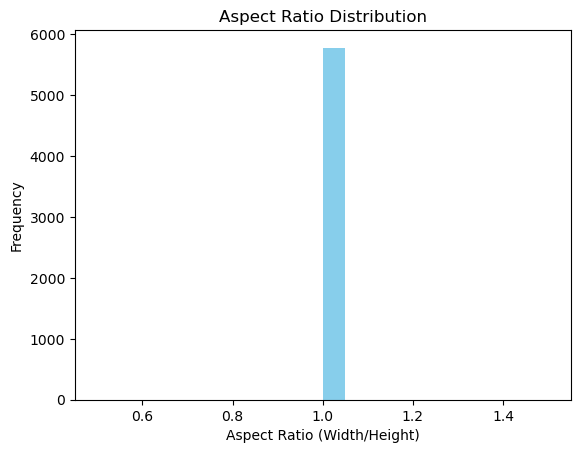

In [18]:
def check_aspect_ratios(df):
    aspect_ratios = []  # Initialize a list to store aspect ratios of images
    
    # Iterate over each image path in the DataFrame
    for img_path in df['image_path']:
        with Image.open(img_path) as img:  # Open the image file
            width, height = img.size  # Get the dimensions of the image
            aspect_ratios.append(width / height)  # Calculate and append aspect ratio (width/height)
    
    # Create a histogram to visualize the distribution of aspect ratios
    plt.hist(aspect_ratios, bins=20, color='skyblue')  # Plot the histogram with 20 bins
    plt.title('Aspect Ratio Distribution')  # Set the title for the histogram
    plt.xlabel('Aspect Ratio (Width/Height)')  # Label for the x-axis
    plt.ylabel('Frequency')  # Label for the y-axis
    plt.show()  # Display the histogram

# Check aspect ratio consistency in the training set
check_aspect_ratios(train_df)  # Call the function for the training dataset

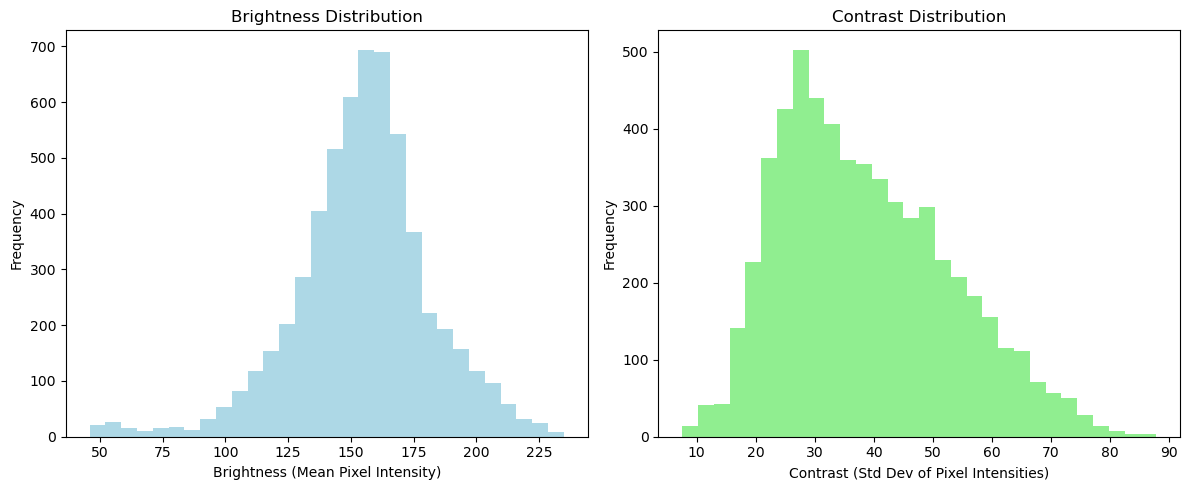

In [19]:
def check_brightness_contrast(df):
    brightness = []  # Initialize a list to store brightness values
    contrast = []  # Initialize a list to store contrast values
    
    # Iterate over each image path in the DataFrame
    for img_path in df['image_path']:
        with Image.open(img_path).convert('L') as img:  # Open the image and convert it to grayscale
            stat = ImageStat.Stat(img)  # Calculate statistics of the image
            brightness.append(stat.mean[0])  # Append average pixel intensity for brightness
            contrast.append(stat.stddev[0])  # Append standard deviation of pixel intensities for contrast
    
    plt.figure(figsize=(12, 5))  # Set figure size for the plots
    
    # Brightness histogram
    plt.subplot(1, 2, 1)  # Create the first subplot for brightness distribution
    plt.hist(brightness, bins=30, color='lightblue')  # Plot the histogram for brightness
    plt.title('Brightness Distribution')  # Set title for brightness histogram
    plt.xlabel('Brightness (Mean Pixel Intensity)')  # Label for the x-axis
    plt.ylabel('Frequency')  # Label for the y-axis

    # Contrast histogram
    plt.subplot(1, 2, 2)  # Create the second subplot for contrast distribution
    plt.hist(contrast, bins=30, color='lightgreen')  # Plot the histogram for contrast
    plt.title('Contrast Distribution')  # Set title for contrast histogram
    plt.xlabel('Contrast (Std Dev of Pixel Intensities)')  # Label for the x-axis
    plt.ylabel('Frequency')  # Label for the y-axis

    plt.tight_layout()  # Adjust layout to prevent overlap of elements
    plt.show()  # Display the histograms

# Check brightness and contrast in the training set
check_brightness_contrast(train_df)  # Call the function for the training dataset

Found 5778 images belonging to 5 classes.


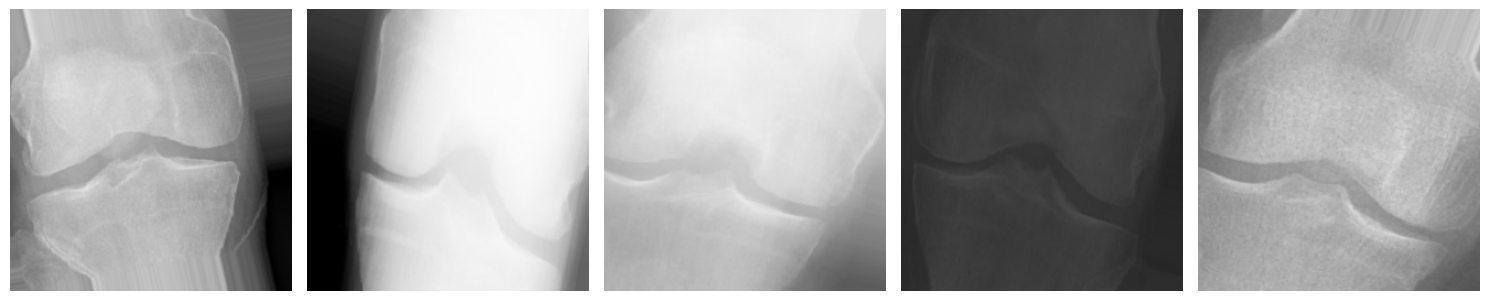

In [20]:
# Define ImageDataGenerator with augmentations
train_datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images by 20 degrees
    width_shift_range=0.1,     # Randomly shift images horizontally by 10%
    height_shift_range=0.1,    # Randomly shift images vertically by 10%
    shear_range=0.2,           # Shear images by 20%
    zoom_range=0.2,            # Random zoom by 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill missing pixels after transformations
)

# Augment training images
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # Directory for training images
    target_size=(256, 256),    # Resize images to a fixed size
    batch_size=32,             # Batch size for training
    class_mode='categorical'   # Multi-class classification
)

# Example: visualize a few augmented images
def show_augmented_images(generator, num_images=5):
    plt.figure(figsize=(15, 5))
    batch = next(generator)  # Get a batch of augmented images
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(batch[0][i].astype('uint8'))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of augmented images
show_augmented_images(train_generator)


In [21]:
import tensorflow as tf

# Define ImageDataGenerator with augmentations
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,         # Randomly rotate images by 20 degrees
    width_shift_range=[-50,0,50,30,-30],     # Randomly shift images horizontally by 10%
    height_shift_range=[-50,0,50,30,-30],    # Randomly shift images vertically by 10%
    shear_range=0.2,           # Shear images by 20%
    zoom_range=0.2,            # Random zoom by 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill missing pixels after transformations
)

# Augment training images
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # Directory for training images
    target_size=(256, 256),    # Resize images to a fixed size
    batch_size=32,             # Batch size for training
    class_mode='categorical'   # Multi-c
)

# Augment validation images
valid_generator = train_datagen.flow_from_directory(
    val_dir,                 # Directory for training images
    target_size=(256, 256),    # Resize images to a fixed size
    batch_size=32,             # Batch size for training
    class_mode='categorical'   # Multi-c
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [22]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [23]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}
{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [24]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01, 
                min_lr=1e-10, patience=4, mode='auto'
            )

In [25]:
model = tf.keras.applications.ResNet50(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)

In [26]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [27]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

epochs=1
history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=256,
    callbacks=[early, plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)


2024-11-09 19:31:36.933103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-09 19:31:36.938972: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


181/181 [==============================] - ETA: 0s - loss: 1.9345 - accuracy: 0.2312

2024-11-09 19:39:41.874229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


181/181 [==============================] - 503s 3s/step - loss: 1.9345 - accuracy: 0.2312 - val_loss: 4.5922 - val_accuracy: 0.3923 - lr: 0.0010


In [28]:
model_name = "ResNet50"
save_model_ft = os.path.join('models', f'model_{model_name}_ft.hdf5')
model_ft.save(save_model_ft)

In [29]:
from sklearn.metrics import *

def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))


In [30]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)


2024-11-09 19:40:05.708202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 18s 663ms/step
Accuracy Score - ResNet50: 0.39
Balanced Accuracy Score - ResNet50: 0.20


              precision    recall  f1-score   support

           0       0.40      0.97      0.57       328
           1       0.35      0.05      0.08       153
           2       0.07      0.00      0.01       212
           3       0.00      0.00      0.00       106
           4       0.00      0.00      0.00        27

    accuracy                           0.39       826
   macro avg       0.16      0.20      0.13       826
weighted avg       0.24      0.39      0.24       826



In [31]:
class_names = [0,1,2,3,4]

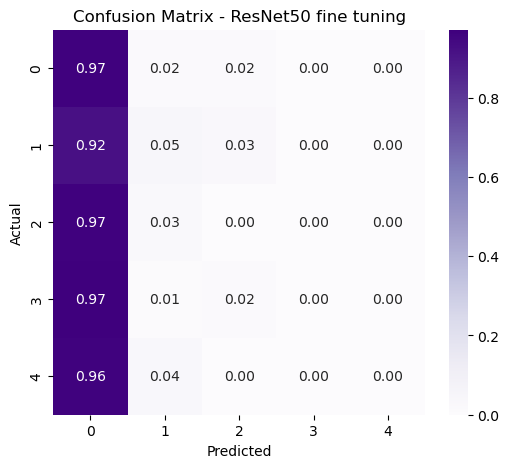

In [32]:
import seaborn as sns

def plot_confusion_matrix(
    ytrue, ypred, class_names, model_name
):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

plot_confusion_matrix(valid_generator, predict_model_ft, class_names, f"{model_name} fine tuning")

From all the metrics displayed above, we can say that model need to be tuned more so that we can make better predictions.

## Testing on sample images

In [33]:
pwd

'/Users/tejakolla/Documents/sem-1/AI Systems/project/AI-ENHANCED-DIAGNOSIS-AND-SEVERITY-PREDICTION-OF-KNEE-OSTEOARTHRITIS/kolla.teja'

In [34]:
target_size =(256, 256)

Simulated - True Class: 2, Predicted Class: 0, Probability: 55.88%
Simulated - True Class: 2, Predicted Class: 2, Probability: 79.54%
Simulated - True Class: 2, Predicted Class: 2, Probability: 51.54%
Simulated - True Class: 1, Predicted Class: 2, Probability: 61.85%
Simulated - True Class: 2, Predicted Class: 2, Probability: 74.03%
Simulated - True Class: 4, Predicted Class: 2, Probability: 80.1%
Simulated - True Class: 0, Predicted Class: 0, Probability: 74.83%
Simulated - True Class: 2, Predicted Class: 3, Probability: 70.62%
Simulated - True Class: 2, Predicted Class: 4, Probability: 66.29%
Simulated - True Class: 4, Predicted Class: 4, Probability: 66.08%


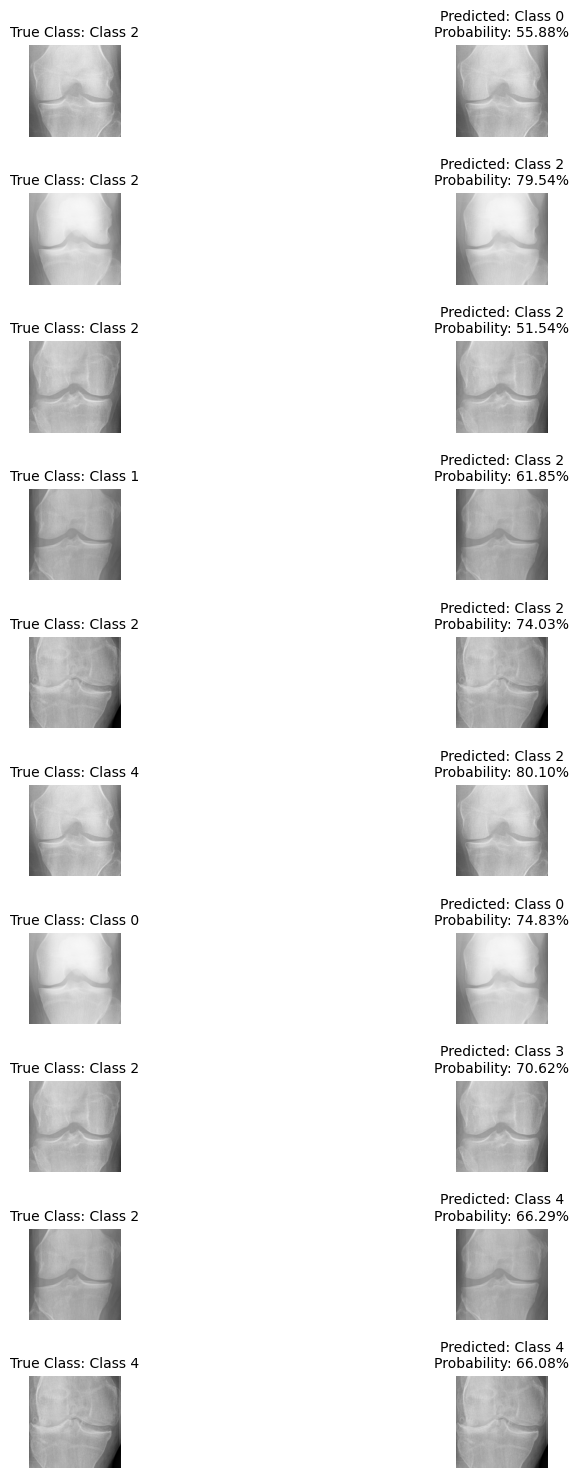

In [36]:
base_dir = r"/Users/tejakolla/Documents/sem-1/AI Systems/project/AI-ENHANCED-DIAGNOSIS-AND-SEVERITY-PREDICTION-OF-KNEE-OSTEOARTHRITIS/dataset/val"
plt.figure(figsize=(10, 12)) 

target_size = (224, 224)

for i in range(5):
    image_folder = os.path.join(base_dir, str(i))
    print(image_folder)
    image_file = os.listdir(image_folder)[0]
    img_path = os.path.join(image_folder, image_file)
    try:
        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) 
        
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

        # Make the prediction
        y_pred = model.predict(img_array)
        y_pred = 100 * y_pred[0]  
        print(y_pred)
        
        # Get the predicted class and its probability
        predicted_class = np.argmax(y_pred)
        probability = np.amax(y_pred)
        print(probability)
        # Display original images
        plt.subplot(5, 2, i * 2 + 1) 
        plt.imshow(img)
        plt.title(f"True Class: {class_names[i]}", fontsize=10)
        plt.axis('off')

        # Display prediction lables
        plt.subplot(5, 2, i * 2 + 2) 
        plt.imshow(img) 
        plt.title(f"Predicted: {class_names[predicted_class]}\nProbability: {probability:.2f}%", fontsize=10)
        plt.axis('off') 

    except Exception as e:
        print(f"Error processing the image {img_path}: {e}")

plt.tight_layout(pad=1.5)
plt.show()

## Need to fine tune the model and make the better predictyions and for now we have tested the model with epoch. I will tune it and explore the more methods to get the better results.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Rescale pixel values
    rotation_range=20,             # Rotate images
    width_shift_range=0.1,         # Horizontal shift
    height_shift_range=0.1,        # Vertical shift
    zoom_range=0.2,                # Zoom
    horizontal_flip=True           # Flip images
)

# For validation and test, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),       # ResNet50 input size
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # For evaluation, maintain the order
)


Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model, exclude top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pretrained weights
base_model.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Add dense layer for more complexity
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


2024-11-10 01:58:35.381401: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-10 01:58:35.381492: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-10 01:58:35.381510: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-10 01:58:35.381558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-10 01:58:35.381608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
# Set training parameters
epochs = 20  # Adjust based on needs and dataset size
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps
)


Epoch 1/20


2024-11-10 01:58:47.891933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


180/180 ━━━━━━━━━━━━━━━━━━━━ 38s 185ms/step - accuracy: 0.3786 - loss: 1.4579 - val_accuracy: 0.3975 - val_loss: 1.4201
Epoch 2/20
  1/180 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.5312 - loss: 1.4153

2024-11-10 01:59:24.920221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 01:59:24.920244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-11-10 01:59:24.920257: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 01:59:24.920261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 01:59:24.920268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 01:59:24.920271: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8479250319299969553
2024-11

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.4153 - val_accuracy: 0.3846 - val_loss: 1.2733
Epoch 3/20


2024-11-10 01:59:25.381186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 01:59:25.381219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 179ms/step - accuracy: 0.3851 - loss: 1.4077 - val_accuracy: 0.4000 - val_loss: 1.4075
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.3750 - loss: 1.4662 - val_accuracy: 0.3077 - val_loss: 1.4865
Epoch 5/20


2024-11-10 01:59:57.905213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 01:59:57.905242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 01:59:57.905250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-11-10 01:59:57.905262: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 01:59:57.905268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 01:59:57.905276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12659148047901476602
2024-1

180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 179ms/step - accuracy: 0.3976 - loss: 1.4184 - val_accuracy: 0.3988 - val_loss: 1.4190
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.4375 - loss: 1.4827 - val_accuracy: 0.3462 - val_loss: 1.3987
Epoch 7/20


2024-11-10 02:00:30.513921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:00:30.513951: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 02:00:30.513955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-11-10 02:00:30.513967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 02:00:30.513973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8479250319299969553
2024-11-10 02:00:30.513976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11

180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 175ms/step - accuracy: 0.3885 - loss: 1.4090 - val_accuracy: 0.2575 - val_loss: 1.4341
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.2500 - loss: 1.3864 - val_accuracy: 0.2308 - val_loss: 1.4778
Epoch 9/20


2024-11-10 02:01:02.504656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:01:02.504690: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 02:01:02.504701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-11-10 02:01:02.504712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 02:01:02.504716: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 02:01:02.504724: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12659148047901476602
2024-1

180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.3800 - loss: 1.4264 - val_accuracy: 0.4087 - val_loss: 1.4223
Epoch 10/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.4688 - loss: 1.4286 - val_accuracy: 0.3846 - val_loss: 1.3302
Epoch 11/20


2024-11-10 02:01:38.240116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:01:38.240138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 02:01:38.240141: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 02:01:38.240145: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12659148047901476602
2024-11-10 02:01:38.240148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-11-10 02:01:38.240159: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-1

180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.4088 - loss: 1.4038 - val_accuracy: 0.3963 - val_loss: 1.4043
Epoch 12/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.5000 - loss: 1.2469 - val_accuracy: 0.4231 - val_loss: 1.4141
Epoch 13/20


2024-11-10 02:02:14.281920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:02:14.281946: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 02:02:14.281950: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 02:02:14.281953: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12659148047901476602
2024-11-10 02:02:14.281956: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 02:02:14.281958: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8479250319299969553
2024-11-10 02:02:14.281978: W tensorflow/core/framework/local_rende

180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.3872 - loss: 1.4208 - val_accuracy: 0.3975 - val_loss: 1.4066
Epoch 14/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.3438 - loss: 1.3717 - val_accuracy: 0.3846 - val_loss: 1.3948
Epoch 15/20


2024-11-10 02:02:50.816919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:02:50.816941: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 02:02:50.816943: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 02:02:50.816946: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12659148047901476602
2024-11-10 02:02:50.816948: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 02:02:50.816951: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8479250319299969553
2024-11-10 02:02:50.816965: W tensorflow/core/framework/local_rende

180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.3869 - loss: 1.4045 - val_accuracy: 0.3938 - val_loss: 1.4424
Epoch 16/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.2812 - loss: 1.6586 - val_accuracy: 0.5000 - val_loss: 1.2351
Epoch 17/20


2024-11-10 02:03:26.129614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:03:26.129651: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 02:03:26.129654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-11-10 02:03:26.129663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 02:03:26.129665: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 02:03:26.129669: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12659148047901476602
2024-1

180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.3849 - loss: 1.4132 - val_accuracy: 0.4000 - val_loss: 1.4073
Epoch 18/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.3125 - loss: 1.4777 - val_accuracy: 0.3077 - val_loss: 1.4832
Epoch 19/20


2024-11-10 02:04:01.534112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:04:01.534141: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 02:04:01.534145: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 02:04:01.534148: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12659148047901476602
2024-11-10 02:04:01.534151: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 02:04:01.534159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-1

180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.3757 - loss: 1.4249 - val_accuracy: 0.3988 - val_loss: 1.4208
Epoch 20/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.4688 - loss: 1.3532 - val_accuracy: 0.3462 - val_loss: 1.5497


2024-11-10 02:04:37.250243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:04:37.250267: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12142366068435460242
2024-11-10 02:04:37.250271: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10569530751952074978
2024-11-10 02:04:37.250274: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12659148047901476602
2024-11-10 02:04:37.250277: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15046168163046256819
2024-11-10 02:04:37.250279: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8479250319299969553
2024-11-10 02:04:37.250283: W tensorflow/core/framework/local_rende

In [25]:
# Unfreeze layers for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers of ResNet50
    layer.trainable = True

# Re-compile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 10  # Adjust as necessary
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=total_epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=history.epoch[-1]
)

Epoch 20/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 43s 213ms/step - accuracy: 0.3875 - loss: 1.4003 - val_accuracy: 0.3950 - val_loss: 1.4354
Epoch 21/30
  1/180 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - accuracy: 0.2812 - loss: 1.4585

2024-11-10 02:05:21.220636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:05:21.220656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_14/_72]]
2024-11-10 02:05:21.220665: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9819364870365549338
2024-11-10 02:05:21.220668: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12210233518777838288
2024-11-10 02:05:21.220675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8170937265615987996
2024-11-10 02:05:21.220678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 144889232

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2812 - loss: 1.4585 - val_accuracy: 0.4615 - val_loss: 1.3806
Epoch 22/30


2024-11-10 02:05:21.676296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:05:21.676314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-10 02:05:21.676325: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13043001848690903607
2024-11-10 02:05:21.676328: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8673433800852238965


180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - accuracy: 0.4012 - loss: 1.3809 - val_accuracy: 0.3988 - val_loss: 1.4105
Epoch 23/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.4688 - loss: 1.3842 - val_accuracy: 0.3462 - val_loss: 1.4038
Epoch 24/30


2024-11-10 02:05:58.573145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:05:58.573163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_60]]
2024-11-10 02:05:58.573177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5872154219321532253
2024-11-10 02:05:58.573180: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6916386466644229896
2024-11-10 02:05:58.573185: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9116624746084819725
2024-11-10 02:05:58.573188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2452257488057926829
2024-11-10

180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.4135 - loss: 1.3536 - val_accuracy: 0.3950 - val_loss: 1.4660
Epoch 25/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.4375 - loss: 1.3739 - val_accuracy: 0.4615 - val_loss: 1.2995
Epoch 26/30


2024-11-10 02:06:36.079219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:06:36.079239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8170937265615987996
2024-11-10 02:06:36.079242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17917996532075017500
2024-11-10 02:06:36.079246: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4404432449820673982
2024-11-10 02:06:36.079248: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5312209066459236236
2024-11-10 02:06:36.079251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7022678045293447978
2024-11-10 02:06:36.079254: I tensorflow/core/framework/local_rendezvo

180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.4312 - loss: 1.3276 - val_accuracy: 0.4137 - val_loss: 1.3279
Epoch 27/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.5312 - loss: 1.1753 - val_accuracy: 0.5000 - val_loss: 1.3287
Epoch 28/30


2024-11-10 02:07:13.244238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:07:13.244260: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4404432449820673982
2024-11-10 02:07:13.244263: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16777756064783253450
2024-11-10 02:07:13.244265: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9819364870365549338
2024-11-10 02:07:13.244267: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8170937265615987996
2024-11-10 02:07:13.244270: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17917996532075017500
2024-11-10 02:07:13.244272: I tensorflow/core/framework/local_rendezv

180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.4359 - loss: 1.3124 - val_accuracy: 0.3487 - val_loss: 1.4301
Epoch 29/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.4375 - loss: 1.3411 - val_accuracy: 0.4615 - val_loss: 1.4655
Epoch 30/30


2024-11-10 02:07:50.604632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-10 02:07:50.604650: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14488923296521266144
2024-11-10 02:07:50.604653: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8170937265615987996
2024-11-10 02:07:50.604655: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4404432449820673982
2024-11-10 02:07:50.604658: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5312209066459236236
2024-11-10 02:07:50.604660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1281866487406299320
2024-11-10 02:07:50.604662: I tensorflow/core/framework/local_rendezvo

180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.4379 - loss: 1.3098 - val_accuracy: 0.4013 - val_loss: 1.2970


In [26]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.4596 - loss: 1.1545
Test accuracy: 0.40
Test loss: 1.30


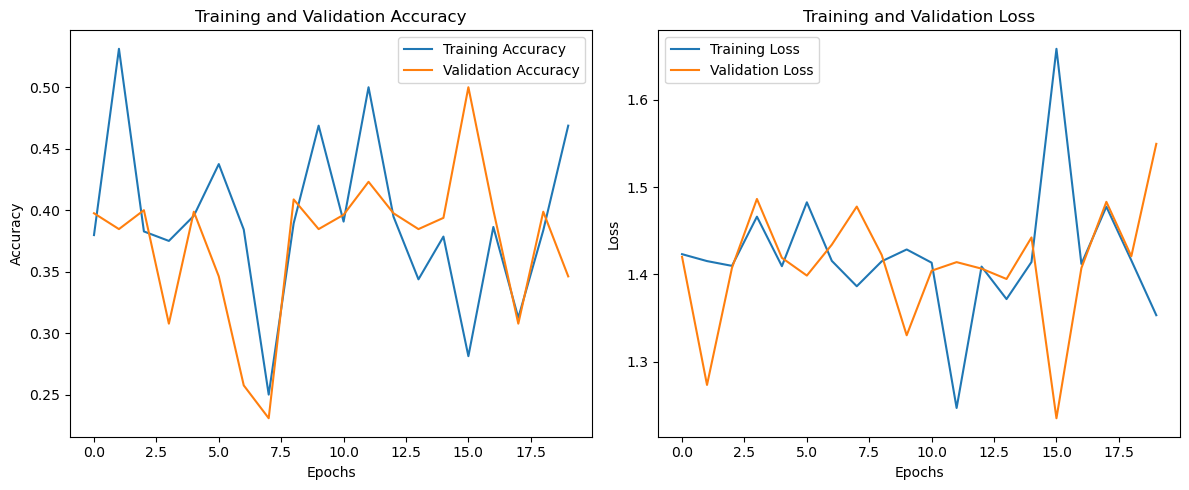

In [27]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_curves(history)
